# Test simulation matching

## Imports

In [1]:
import sys
import os
import pprint
import cPickle as pickle
import numpy as np
from matplotlib import pyplot as plt
gleam_root = "/Users/phdenzel/gleam"
sys.path.append(gleam_root)
from gleam.reconsrc import ReconSrc
from gleam.utils.plotting import IPColorbar, IPPointCache
from gleam.utils.plotting import plot_scalebar, plot_labelbox
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()
from mcmc_matching import load_lo, load_lm

## Load lensing data and models

In [2]:
ids = ['SDSSJ0029-0055', 'SDSSJ0737+3216', 'SDSSJ0753+3416', 'SDSSJ0956+5100',
       'SDSSJ1051+4439', 'SDSSJ1430+6104', 'SDSSJ1627-0053']
idx = 0
lens = ids[idx]
pixrad = 11
sigf = 2e+1

In [3]:
lo = load_lo(lens, verbose=True)

# <LensObject>
Properties of that field are unknown [None]
filename            	SDSSJ0029-0055.json
filepath            	/Users/phdenzel/slacs-match/data/SDSSJ0029-0055.json
band                	
naxis1              	99
naxis2              	99
naxis_plus          	None
refval              	[7.2962736899742, -0.92610179418719]
refpx               	[-949.50000000016, 385.99999999984]
center              	<7.2824, -0.9308>
px2deg              	[1.3888888888888002e-05, 1.38888888888896e-05]
px2arcsec           	[0.049999999999996804, 0.050000000000002556]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x12118d578>
roi                 	ROISelector(99, 99)
lens                	None
srcimgs             	[]
zl                  	0.5
zs                  	3.0
mapr                	2.475
tdelay              	None
tderr               	None
light_model         	{}
stel_mass           	None
glscfactory         	GLSCFactory(zl

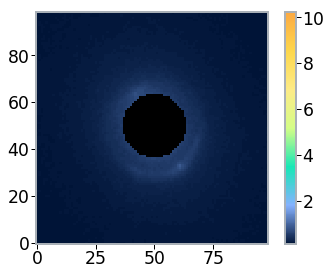

In [4]:
# %matplotlib notebook

fig, ax = plt.subplots()
plt_out = plt.imshow(lo.data, origin='lower', cmap='vilux')
cb = plt.colorbar()

msk = np.zeros(lo.roi.mask.shape + (4,))
msk[:, :, 3] = lo.roi.mask
plt.imshow(msk, origin='lower')
plt.show()

# clrbar = IPColorbar(cb, plt_out)
# clrbar.connect()

In [5]:
lm = load_lm(lens, update_pixrad=pixrad, verbose=True)

# <LensModel>
filename            	SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl
filepath            	models/SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl
N                   	697
pixrad              	11
maprad              	4.0
pixel_size          	0.347826086957
kappa               	None
minima              	[]
saddle_points       	[]
maxima              	[]
zl                  	0.227
zs                  	0.9313



## Original and resampled model maps

In [6]:
print lm.data.shape
print lm.resampled['obj'].data.shape

(697, 161, 161)
(697, 23, 23)


In [7]:
print "# <LensModel.resampled>"
print lm.resampled['obj'].__v__

# <LensModel.resampled>
filename            	SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl
filepath            	models/SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl
N                   	697
pixrad              	11
maprad              	4.0
pixel_size          	0.347826086957
kappa               	None
minima              	[]
saddle_points       	[]
maxima              	[]
zl                  	0.227
zs                  	0.9313


### Inspect source reconstruction and synthetics

In [8]:
print "# <ReconSrc>"
reconsrc = ReconSrc(lo, lm.resampled['obj'], M=80, M_fullres=256, mask_keys=['circle'])
print(reconsrc.__v__ + "\n")
sig2 = sigf*np.sqrt(reconsrc.lensobject.data)

# <ReconSrc>
lensobject          	LensObject(@[7.2824, -0.9308])
model               	<LensModel@SDSSJ0029-0055_kappa_re097_zl023zs093>
mask_keys           	['circle']
M                   	80
N                   	161
r_max               	None
M_fullres           	256
N_fullres           	513
r_fullres           	None
N_nil               	0
rotation            	0



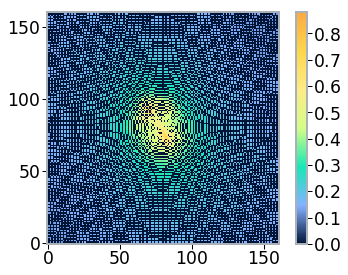

In [9]:
# %matplotlib notebook
srcmap = reconsrc.plane_map(method='lsqr', use_psf=False, use_mask=True)

fig, ax = plt.subplots()
plt_out = plt.imshow(srcmap, origin='lower', cmap='vilux')
cb = plt.colorbar()

# clrbar = IPColorbar(cb, plt_out)
# clrbar.connect()

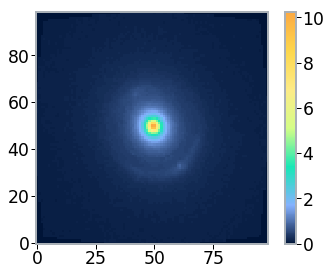

In [10]:
# %matplotlib notebook
synth = reconsrc.reproj_map(method='lsqr', use_psf=False, use_mask=True)

fig, ax = plt.subplots()
plt_out = plt.imshow(synth, origin='lower', cmap='vilux')
cb = plt.colorbar()

# clrbar = IPColorbar(cb, plt_out)
# clrbar.connect()

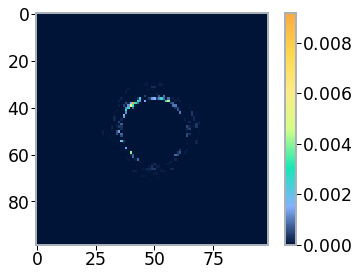

In [11]:
# %matplotlib notebook
resid = reconsrc.residual_map(method='lsqr', use_psf=False, use_mask=True, nonzero_only=True)

fig, ax = plt.subplots()
plt_out = plt.imshow(resid, cmap='vilux')
cb = plt.colorbar()

# clrbar = IPColorbar(cb, plt_out)
# clrbar.connect()